✅ このパイプラインでできること

CSVのsignal_indexに対応するnpyデータのみ抽出

SBPと患者IDを同期

5mmHgごとのsbp_binラベル付与

sbp_binごとに患者IDを考慮したダウンサンプリング（各ビンのサンプル数を均一化）

波形（BP/PPG）とラベルを揃えて保存

In [1]:
import numpy as np
import pandas as pd

# ---------------------------
# データ抽出 + ビン付け
# ---------------------------
def prepare_with_bins(
    wave_npy_path,
    sbp_npy_path,
    subject_npy_path,
    feature_csv_path
):
    """
    CSV の signal_index に基づき npy からデータを抽出。
    sbp, subject を同期して取得。
    5mmHgビン sbp_bin も付与。
    """
    waves = np.load(wave_npy_path).squeeze()  # (N, 2, 1250) or (N, 1250)         
    sbp_all = np.load(sbp_npy_path)        
    subjects_all = np.load(subject_npy_path) 
    df = pd.read_csv(feature_csv_path)      
    print(f"Loaded npy: {waves.shape}, csv: {df.shape}",waves.ndim)
    idx = df["signal_index"].values

    sbp = sbp_all[idx]
    subject = subjects_all[idx]
    if waves.ndim != 2:
        waves = waves[idx, 1, :]        # (N, 1, 1250)
    sbp_bin = (sbp // 5).astype(int)
    df["sbp_bin"] = sbp_bin
    # df["subject_id"] = subject
    return df, waves


# ---------------------------
# ビンごとに患者IDを考慮してダウンサンプリング
# ---------------------------
def stratified_downsample(df, ppg_wave, random_state=42):
    """
    sbp_binごとに、患者IDを混ぜた状態でサンプル数を揃える。
    """
    # ビンごとの最小サンプル数
    min_count = df.groupby("sbp_bin").size().min()
    print(df.groupby("sbp_bin").size())
    sampled_idx = []
    for b, group in df.groupby("sbp_bin"):
        sampled = group.sample(n=min_count, replace=False, random_state=random_state)
        sampled_idx.append(sampled.index.values)

    sampled_idx = np.concatenate(sampled_idx)

    return df.iloc[sampled_idx].reset_index(drop=True), ppg_wave[sampled_idx]




In [9]:
def merge_extreme_bins(df, ratio_threshold=0.01, verbose=True):
    """
    sbp_binごとに、両端の極端なビンを1つにまとめる
    ratio_threshold: 全体に対する累積比率でまとめる範囲を決める
    """
    # sbp_binごとの件数
    counts = df['sbp_bin'].value_counts().sort_index()  # 小さい順
    if verbose: 
        print("Before merging extreme bins:")
        print(counts)
    total = counts.sum()
    if verbose:
        print(f"Total samples: {total}")    
    # 左端（低血圧側）
    cum_left = counts.cumsum() / total
    left_bins_to_merge = cum_left[cum_left <= ratio_threshold].index
    if verbose:
        print(cum_left)
    # 右端（高血圧側）
    cum_right = counts[::-1].cumsum() / total
    right_bins_to_merge = cum_right[cum_right <= ratio_threshold].index
    if verbose:
        print(cum_right)
    # 新しい sbp_bin 列
    df = df.copy()
    if len(left_bins_to_merge) > 0:
        min_bin = left_bins_to_merge.max()
        df.loc[df['sbp_bin'].isin(left_bins_to_merge), 'sbp_bin'] = min_bin

    if len(right_bins_to_merge) > 0:
        max_bin = right_bins_to_merge.min()
        df.loc[df['sbp_bin'].isin(right_bins_to_merge), 'sbp_bin'] = max_bin

    return df,max(left_bins_to_merge) if len(left_bins_to_merge) > 0 else None,min(right_bins_to_merge) if len(right_bins_to_merge) > 0 else None

In [2]:

def extract_data_by_csv(npy_path, csv_path):
    """
    npy と csv を読み込み、csv の signal_index に対応するデータだけ抜き出す。
    
    return:
        df: csv（特徴量 + sbp + sbp_bin 追加）
        bp_wave: shape = (M, 1250)
        ppg_wave: shape = (M, 1250)
    """
    # ---- load files ----
    data = np.load(npy_path).squeeze()               # (N, 2, 1250)
    df = pd.read_csv(csv_path)             # 包含 signal_index, subject, features...
    print(f"Loaded npy: {data.shape}, csv: {df.shape}")
    # signal_index を取得
    idx = df["signal_index"].values

    # ---- extract npy rows ----
    if data.ndim != 2:
        data = data[:, 1, :]      # (N, 1, 1250)

    # ---- derive SBP representative (max recommended for waveform SBP) ----
    sbp = df["sbp"]             # 必要なら max に変更可
    sbp_bin = (sbp // 5).astype(int)       # 5 mmHg bin

    # ---- append to dataframe ----
    df["sbp_bin"] = sbp_bin
    
    return df,data


In [3]:
def stratified_downsample_per_subject(df, ppg_wave, random_state=42):
    """
    sbp_binごとに、各患者(subject)のサンプル数をなるべく均等に揃えてダウンサンプリングする
    """
    sampled_idx = []

    for b, bin_group in df.groupby("sbp_bin"):
        # このビン内の各患者ごとのサンプル数
        patient_counts = bin_group["subject"].value_counts()
        min_per_patient = patient_counts.min()  # このビン内で患者ごとの最小サンプル数

        for patient, patient_group in bin_group.groupby("subject"):
            # 最小サンプル数までダウンサンプリング
            n_samples = min(min_per_patient, len(patient_group))
            sampled = patient_group.sample(n=n_samples, replace=False, random_state=random_state)
            sampled_idx.append(sampled.index.values)

    sampled_idx = np.concatenate(sampled_idx)

    return df.iloc[sampled_idx].reset_index(drop=True),  ppg_wave[sampled_idx]


In [4]:


def stratified_downsample_max_ratio(df, ppg_wave, max_ratio=0.04, random_state=42):
    """
    sbp_binごとに、subjectごとのサンプル数を均等に保ちながら、
    各ビンを全体サンプル数の max_ratio までダウンサンプリングする。
    """
    df = df.copy()
    total_samples = len(df)
    max_samples_per_bin = int(total_samples * max_ratio)
    
    sampled_idx = []

    for b, bin_group in df.groupby("sbp_bin"):
        # このビンのサンプル数
        n_samples_bin = len(bin_group)

        if n_samples_bin <= max_samples_per_bin:
            # ビンのサンプルが少なければそのまま
            sampled_idx.append(bin_group.index.values)
            continue

        # subjectごとのグループ
        subjects = bin_group['subject'].unique()
        n_subjects = len(subjects)
        
        # 各subjectに割り当てるサンプル数
        n_per_subject = max_samples_per_bin // n_subjects
        
        # 各subjectから n_per_subject サンプル抽出
        bin_sampled_idx = []
        for sub in subjects:
            sub_group = bin_group[bin_group['subject'] == sub]
            n_sub = min(len(sub_group), n_per_subject)
            sampled = sub_group.sample(n=n_sub, replace=False, random_state=random_state)
            bin_sampled_idx.append(sampled.index.values)

        sampled_idx.append(np.concatenate(bin_sampled_idx))

    # 結合
    sampled_idx = np.concatenate(sampled_idx)

    return df.iloc[sampled_idx].reset_index(drop=True), ppg_wave[sampled_idx]


In [28]:
def stratified_downsample_max_ratio(df, ppg_wave, max_ratio=0.04, random_state=42):
    """
    sbp_binごとに、subjectごとのサンプル数を均等に保ちながら、
    各ビンを全体サンプル数の max_ratio までダウンサンプリングする。
    残りの枠はサンプルが多いsubjectに再分配。
    """
    df = df.copy()
    total_samples = len(df)
    max_samples_per_bin = int(total_samples * max_ratio)
    
    sampled_idx = []

    for b, bin_group in df.groupby("sbp_bin"):
        n_samples_bin = len(bin_group)

        if n_samples_bin <= max_samples_per_bin:
            sampled_idx.append(bin_group.index.values)
            continue

        subjects = bin_group['subject'].unique()
        n_subjects = len(subjects)
        
        # 各subjectの抽出可能な最大数
        sub_counts = bin_group['subject'].value_counts()
        n_per_subject = max_samples_per_bin // n_subjects
        remaining = max_samples_per_bin

        bin_sampled_idx = []

        # 最初に min(n_per_subject, sub_count) を割り当て
        for sub in subjects:
            sub_group = bin_group[bin_group['subject'] == sub]
            n_sub = min(len(sub_group), n_per_subject, remaining)
            sampled = sub_group.sample(n=n_sub, replace=False, random_state=random_state)
            bin_sampled_idx.append(sampled.index.values)
            remaining -= n_sub

        # 残りの枠を再分配（サンプルが残っているsubjectからランダムに）
        if remaining > 0:
            leftovers = bin_group.drop(np.concatenate(bin_sampled_idx))
            if len(leftovers) > 0:
                extra_sampled = leftovers.sample(n=min(len(leftovers), remaining), random_state=random_state)
                bin_sampled_idx.append(extra_sampled.index.values)

        sampled_idx.append(np.concatenate(bin_sampled_idx))

    sampled_idx = np.concatenate(sampled_idx)
    return df.iloc[sampled_idx].reset_index(drop=True), ppg_wave[sampled_idx]


In [8]:
def merge_extreme_bins_test(df_test, left_merge_value, right_merge_value):
    """
    train の基準値を使って test データの両端ビンをまとめる
    """
    df_merged = df_test.copy()

    if left_merge_value is not None:
        df_merged.loc[df_merged['sbp_bin'] <= left_merge_value, 'sbp_bin'] = left_merge_value
    if right_merge_value is not None:
        df_merged.loc[df_merged['sbp_bin'] >= right_merge_value, 'sbp_bin'] = right_merge_value

    return df_merged


### run

In [29]:

# ---------------------------
# パイプライン実行例
# ---------------------------

# train
train_df, train_ppg_wave = prepare_with_bins(
    wave_npy_path=r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\PulseDB\train_4.npy",
    sbp_npy_path=r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\PulseDB\train_sbp.npy",
    subject_npy_path=r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\PulseDB\train_subjects.npy",
    feature_csv_path=r"F:\minowa\BloodPressureEstimation\data\results\ppg_features_pulsedb_train_all.csv"
)
train_df_merged,left,right = merge_extreme_bins(train_df, ratio_threshold=0.002, verbose=False)
print("Merged left bins:", left, "right bins:", right)
train_df_bal, train_ppg_bal = stratified_downsample_max_ratio(train_df_merged, train_ppg_wave, max_ratio=0.04)

# test
test_df, test_ppg_wave = prepare_with_bins(
wave_npy_path=r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\PulseDB\test_4.npy",
    sbp_npy_path=r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\PulseDB\test_sbp.npy",
    subject_npy_path=r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\PulseDB\test_subjects.npy",
    feature_csv_path=r"F:\minowa\BloodPressureEstimation\data\results\ppg_features_pulsedb_test_all.csv"

)
test_df_merged = merge_extreme_bins_test(test_df, left, right)
test_df_bal, test_ppg_bal = stratified_downsample_max_ratio(test_df_merged, test_ppg_wave, max_ratio=0.04)


# ---------------------------
# 保存例
# ---------------------------
# train_df_bal.to_csv("train_labels_bal.csv", index=False)
# np.save("train_ppg_bal.npy", train_ppg_bal)

# test_df_bal.to_csv("test_labels_bal.csv", index=False)
# np.save("test_ppg_bal.npy", test_ppg_bal)
print("train", train_df_bal.shape, train_ppg_bal.shape)
print("test", test_df_bal.shape, test_ppg_bal.shape)

Loaded npy: (902160, 1250), csv: (730808, 103) 2
Merged left bins: 12 right bins: 39
Loaded npy: (111600, 1250), csv: (90289, 103) 2
train (448377, 104) (448377, 1250)
test (54892, 104) (54892, 1250)


In [27]:
train_df_bal.groupby("sbp_bin").size()

sbp_bin
12      835
13      965
14     2434
15     5451
16    11525
17    22494
18    19191
19    21012
20    22715
21    24518
22    23609
23    23848
24    23096
25    23168
26    22031
27    20045
28    17333
29    24440
30    18278
31    13275
32     9724
33     6376
34     4286
35     2561
36     1592
37      955
38      574
39     1060
dtype: int64

29232.32
[ 10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90  95
 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185
 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275
 280 285]


Text(0.5, 23.52222222222222, 'SBP (mmHg)')

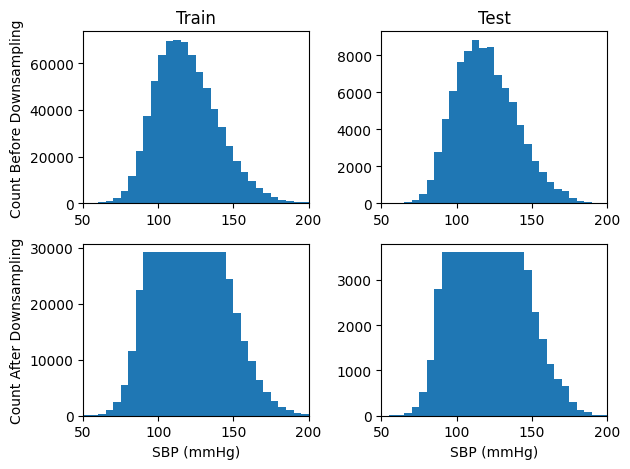

In [39]:
import matplotlib.pyplot as plt; 
plt.subplot(221)
plt.hist(train_df['sbp'],bins=np.arange(train_df['sbp_bin'].min()*5, train_df['sbp_bin'].max()*5+5,5))
plt.xlim(50,200)
plt.title("Train")
plt.ylabel("Count Before Downsampling")
plt.subplot(223)
plt.xlabel("SBP (mmHg)")
plt.ylabel("Count After Downsampling")
plt.hist(train_df_bal['sbp'],bins=np.arange(train_df['sbp_bin'].min()*5, train_df['sbp_bin'].max()*5+5,5))
plt.xlim(50,200)
plt.subplot(222)
plt.hist(test_df['sbp'],bins=np.arange(test_df['sbp_bin'].min()*5, test_df['sbp_bin'].max()*5+5,5))
plt.title("Test")
plt.xlim(50,200)
plt.subplot(224)
plt.hist(test_df_bal['sbp'],bins=np.arange(test_df['sbp_bin'].min()*5, test_df['sbp_bin'].max()*5+5,5))
plt.xlim(50,200)
# plt.subplot(212)
print(len(train_df)*0.04)
print(np.arange(train_df['sbp_bin'].min()*5, train_df['sbp_bin'].max()*5+5,5))
plt.tight_layout()
plt.xlabel("SBP (mmHg)")

In [37]:
train_df.shape

(730808, 105)

In [40]:
train_df_merged = merge_extreme_bins(train_df, ratio_threshold=0.002)
print(train_df_merged['sbp_bin'].value_counts().sort_index())

Before merging extreme bins:
sbp_bin
2         1
3         1
4        12
5        15
6        44
7        31
8        25
9        46
10       98
11      183
12      379
13      965
14     2434
15     5451
16    11525
17    22494
18    37464
19    52203
20    63601
21    69373
22    70161
23    69128
24    63516
25    56180
26    49361
27    40245
28    32751
29    24440
30    18278
31    13275
32     9724
33     6376
34     4286
35     2561
36     1592
37      955
38      574
39      392
40      257
41      211
42       87
43       34
44       42
45       18
46        8
47        4
48        3
49        2
51        1
57        1
Name: count, dtype: int64
Total samples: 730808
sbp_bin
2     0.000001
3     0.000003
4     0.000019
5     0.000040
6     0.000100
7     0.000142
8     0.000177
9     0.000239
10    0.000374
11    0.000624
12    0.001143
13    0.002463
14    0.005794
15    0.013252
16    0.029023
17    0.059802
18    0.111066
19    0.182498
20    0.269526
21    0.364453
22    0

In [32]:

train_df_bal, train_ppg_bal = stratified_downsample(train_df, train_ppg_wave)


sbp_bin
2         1
3         1
4        12
5        15
6        44
7        31
8        25
9        46
10       98
11      183
12      379
13      965
14     2434
15     5451
16    11525
17    22494
18    37464
19    52203
20    63601
21    69373
22    70161
23    69128
24    63516
25    56180
26    49361
27    40245
28    32751
29    24440
30    18278
31    13275
32     9724
33     6376
34     4286
35     2561
36     1592
37      955
38      574
39      392
40      257
41      211
42       87
43       34
44       42
45       18
46        8
47        4
48        3
49        2
51        1
57        1
dtype: int64


### test

In [10]:
# ダウンサンプリング実行
# df_bal, bp_bal, ppg_bal = stratified_downsample_per_subject(train_df, train_bp_wave, train_ppg_wave)

# sbp_binごと、subjectごとのサンプル数を集計
counts = train_df_bal.groupby(["sbp_bin", "subject_id"]).size().unstack(fill_value=0)
counts = test_df_bal.groupby(["sbp_bin", "subject_id"]).size().unstack(fill_value=0)

print("各 sbp_bin 内の各患者のサンプル数（行=sbp_bin, 列=subject）")
print(counts)

# 最小値・最大値・標準偏差などで均等性を確認
print("\n統計情報")
print("最小:", counts.min(axis=1).values)
print("最大:", counts.max(axis=1).values)
print("標準偏差:", counts.std(axis=1).values)

# ヒートマップで視覚化（matplotlib/seaborn使用）
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.heatmap(counts, annot=False, fmt="d", cmap="CMRmap")
plt.xlabel("Subject ID")
plt.ylabel("SBP Bin")
plt.title("SBP Bin × Subject Sample Count (After Downsampling)")
plt.show()


NameError: name 'train_df_bal' is not defined

In [31]:
train_df_bal.groupby("sbp_bin").size()

sbp_bin
2        1
3        1
4        3
5        3
6        4
7        5
8        8
9       13
10      31
11      44
12      88
13     197
14     424
15     702
16    1034
17    1421
18    1719
19    1956
20    2103
21    2230
22    2269
23    2292
24    2264
25    2202
26    2078
27    1937
28    1731
29    1520
30    1314
31    1063
32     883
33     689
34     534
35     368
36     266
37     174
38     106
39      77
40      58
41      44
42      34
43      17
44      18
45       7
46       6
47       3
48       3
49       2
51       1
57       1
dtype: int64

In [64]:
subject_counts = train_df_bal['subject_id'].value_counts()
print("各患者のサンプル数:")
print(subject_counts.to_string())

各患者のサンプル数:
subject_id
63130    358
88685    358
84629    357
1791     357
52087    356
60983    356
98226    353
64538    353
97158    353
69501    352
55090    352
64277    352
88471    351
6621     350
23657    350
86210    350
72908    349
73608    349
40000    348
91004    348
78506    348
93784    347
2667     346
84938    346
59807    345
5525     344
58099    342
81797    342
40305    342
40882    342
71645    338
5382     338
5802     338
88552    336
29035    336
72377    335
40767    335
51909    335
48425    334
5312     331
79762    331
40569    330
6002     330
1481     329
89544    328
5033     328
18975    327
23325    327
47234    324
1933     323
22383    322
3225     320
49067    320
47255    320
67468    318
40673    318
60274    318
59991    317
56583    317
66692    316
54969    314
68991    313
3174     312
29120    311
55772    311
53567    311
683      311
89291    311
60735    310
32020    310
87913    309
94105    309
88111    309
2543     307
59883    307
424

## save

In [41]:
save_root = r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\Downsampled"
# mkdir
import os
os.makedirs(save_root, exist_ok=True)

In [42]:
sbp = train_df_bal["sbp"].values
sbp_bin = train_df_bal["sbp_bin"].values
np.save(os.path.join(save_root, "train_sbp.npy"), sbp)
np.save(os.path.join(save_root, "train_sbp_bin.npy"), sbp_bin)
np.save(os.path.join(save_root, "train_ppg.npy"), train_ppg_bal)
train_df_bal.to_parquet(os.path.join(save_root, "train_features.parquet"))
test_sbp = test_df_bal["sbp"].values
test_sbp_bin = test_df_bal["sbp_bin"].values
np.save(os.path.join(save_root, "test_sbp.npy"), test_sbp)
np.save(os.path.join(save_root, "test_sbp_bin.npy"), test_sbp_bin)
np.save(os.path.join(save_root, "test_ppg.npy"), test_ppg_bal)
test_df_bal.to_parquet(os.path.join(save_root, "test_features.parquet"))

In [50]:
import numpy as np
a = np.load(r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\PulseDB\train_4.npy")
a = a.squeeze()
a.shape
np.save(r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\train_ppg.npy",a.squeeze())

In [53]:
a = np.load(r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\PulseDB\test_4.npy")
a = a.squeeze()
np.save(r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\test_ppg.npy",a.squeeze())
a.shape

(111600, 1250)

In [46]:
df = pd.read_csv(r"F:\minowa\BloodPressureEstimation\data\results\ppg_features_pulsedb_train_all.csv")
df.shape
df.to_parquet(r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\ppg_features_pulsedb_train_all.parquet")

In [54]:
df = pd.read_csv(r"F:\minowa\BloodPressureEstimation\data\results\ppg_features_pulsedb_test_all.csv")
df.to_parquet(r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\ppg_features_pulsedb_test_all.parquet")
df.shape

(90289, 103)

In [48]:
a = np.load(os.path.join(save_root, "train_ppg.npy"))
a.shape

(448377, 1250)

In [55]:
df2 = pd.read_parquet(r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\ppg_features_pulsedb_test_all.parquet")
df2.shape

(90289, 103)

In [56]:
np.load(r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\train_ppg.npy").shape

(902160, 1250)

In [58]:
np.load(r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\train_dbp.npy").shape

(902160,)

In [ ]:
np.load(r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\test_dbp.npy").shape,np.load(r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\test_ppg.npy").shape,np.load(r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\test_sbp.npy").shape,

((111600,), (111600, 1250), (111600,))

In [64]:
np.load(r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\PulseDB\train_subjects.npy").shape

(902160,)